# DSCI 100 006 Group 32 Project Proposal
## Taiwan Housing Prices K Nearest Neighbour Regression Analysis
### Jim Geng, Madalyn Stekl, William Kawira, Shikha Rajesh  

### Introduction

**Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal**

Real estate valuation is the process of determining a property's economic value. It is very important for the real estate market to determine how much houses are worth, so sellers can determine a potentially competitive price they should list their house for, and so buyers can make informed decisions towars their real estate acquisitions. Supply and demand are big drivers of the real estate market, but other variables such as age, condition, square footage, date of sale, terms and conditions of sale, location, lot size, and distance to amenities are all taken into account when a property is evaluated. 

**Clearly state the question you will try to answer with your project**

The goal of our project is to establish the relationship between the price of the house and other variables such as house age, the distance to the nearest MRT station, and the number of convenience stores within a walkable distance. 

**Identify and describe the dataset that will be used to answer the question**

Our dataset is a historical record of real estate evaluation in the Sindian District of New Taipei City, Taiwan. The dataset is comprised of the observation number, the date that the house was evaluated, the age of the house in years, the distance to the nearest Mass Rapid Transit (MRT) station in meters, the number of convenience stores in walking distance, the latitude and longitude in degrees, and finally the house price per unit area (10000 New Taiwan Dollar per Ping ~ 3.3m²). There are 414 observations in the dataset, taken between August of 2012 and July of 2013.

### Preliminary Exploratory Data Analysis

In [1]:
# importing libraries

library(readxl)
library(repr)
library(readr)
library(ggplot2)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ purrr   0.3.4     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   mas

**1. Demonstrate that the dataset can be read from the web into R**

In [2]:
# file download
house_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00477/Real%20estate%20valuation%20data%20set.xlsx"
dest_file <- "Real estate valuation data set.xlsx"
download.file(house_url, dest_file)

# read file
house_data <- read_xlsx("Real estate valuation data set.xlsx")
house_data

No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2012.917,32.0,84.87882,10,24.98298,121.5402,37.9
2,2012.917,19.5,306.59470,9,24.98034,121.5395,42.2
3,2013.583,13.3,561.98450,5,24.98746,121.5439,47.3
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
412,2013.25,18.8,390.96960,7,24.97923,121.5399,40.6
413,2013.00,8.1,104.81010,5,24.96674,121.5407,52.5
414,2013.50,6.5,90.45606,9,24.97433,121.5431,63.9


**2. Clean and wrangle your data into a tidy format**

In [3]:
# cleaning column names and removing extraneous columns.
house_data <- house_data |> 
    rename(
        age = "X2 house age",
        station_distance = "X3 distance to the nearest MRT station",
        store_count = "X4 number of convenience stores",
        price_per_unit = "Y house price of unit area"
    ) |>
    select(-c("No", "X1 transaction date", "X5 latitude", "X6 longitude")) |>
    mutate(store_count = store_count)
house_data

age,station_distance,store_count,price_per_unit
<dbl>,<dbl>,<dbl>,<dbl>
32.0,84.87882,10,37.9
19.5,306.59470,9,42.2
13.3,561.98450,5,47.3
⋮,⋮,⋮,⋮
18.8,390.96960,7,40.6
8.1,104.81010,5,52.5
6.5,90.45606,9,63.9


In [4]:
# splitting data into training and testing sets.
house_split <- initial_split(house_data, prop = 0.75, strata = price_per_unit)
house_train <- training(house_split)
house_test <- testing(house_split)

**3. Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data.**

In [5]:
# summary statistics
house_train_mean <- house_train |>
    summarize(across(age:price_per_unit, mean))
house_train_mean

age,station_distance,store_count,price_per_unit
<dbl>,<dbl>,<dbl>,<dbl>
17.74935,1112.074,4.068182,38.06396


Our data does not have any missing values, nor does it have any discrepancies in the amount of observations in each class, so here we have printed out the mean of each predictor variable.

**4. Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.**

Some preliminary visualizations we can create are various scatterplots plotting our chosen predictor variables vs. the house price. This will establish some general hints as to whether or not there are strong enough relationships between the variables to use them for our regression analysis.

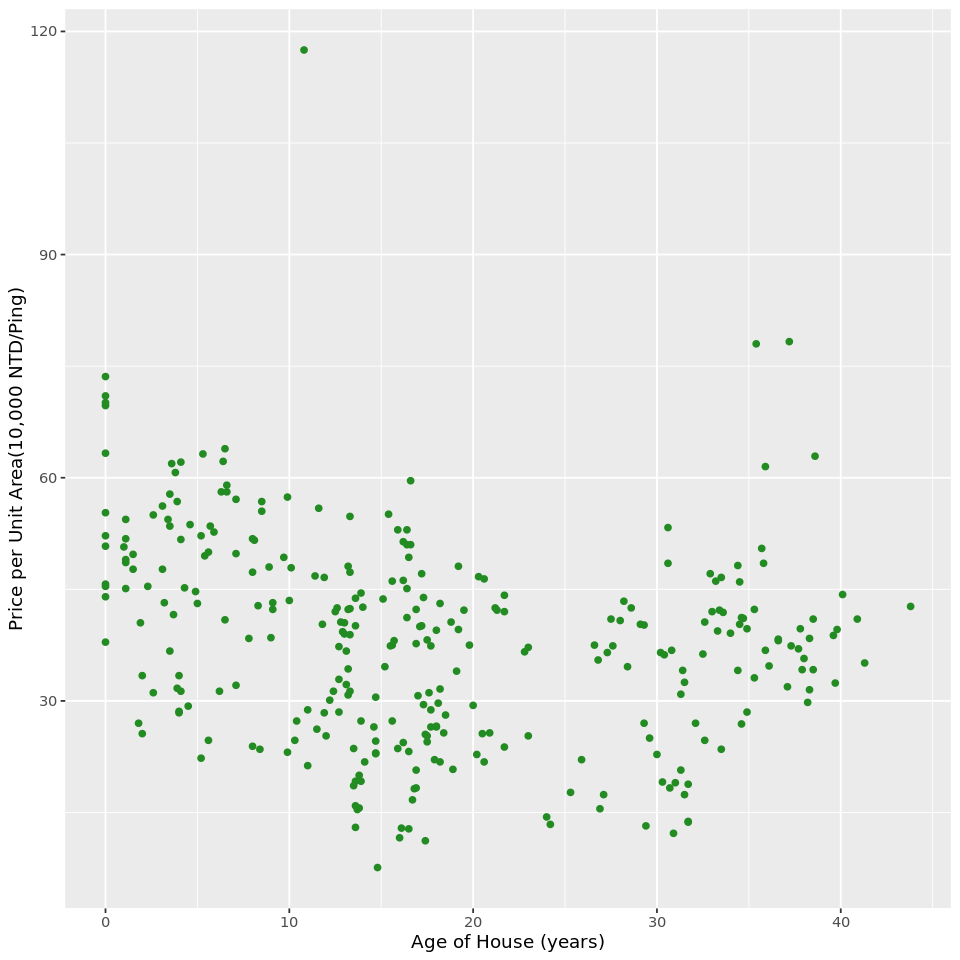

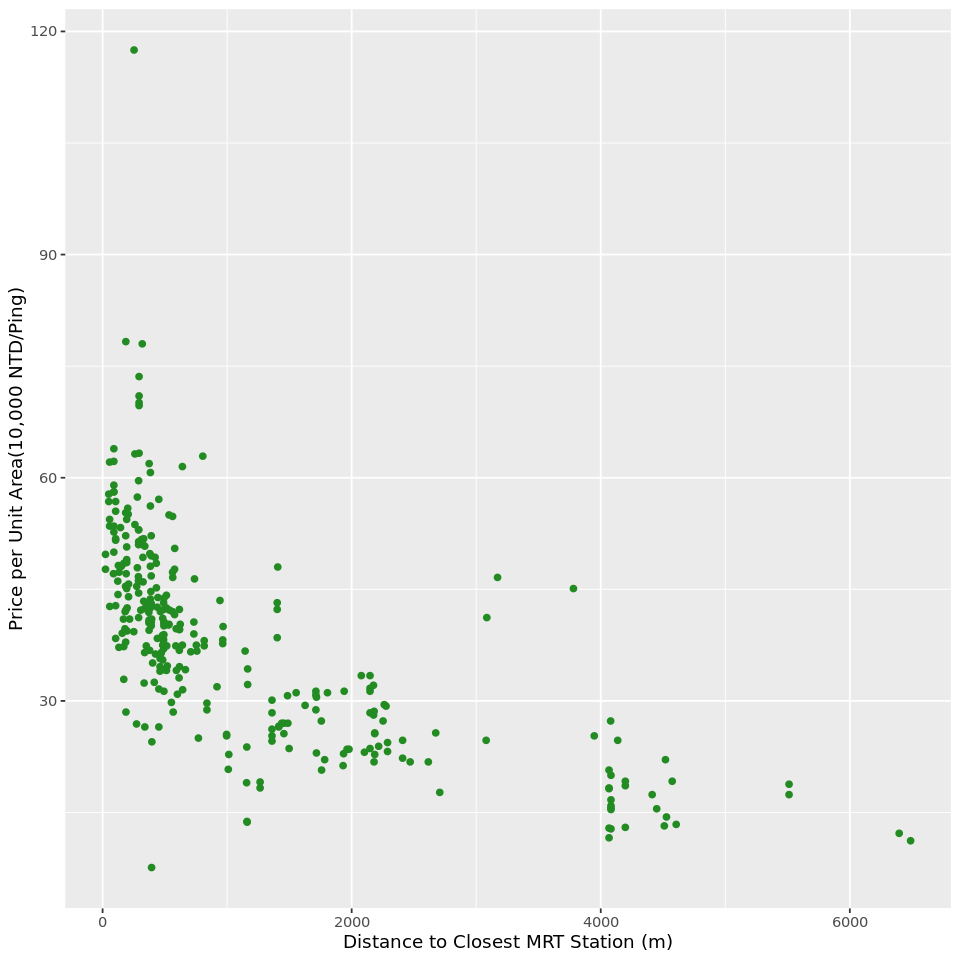

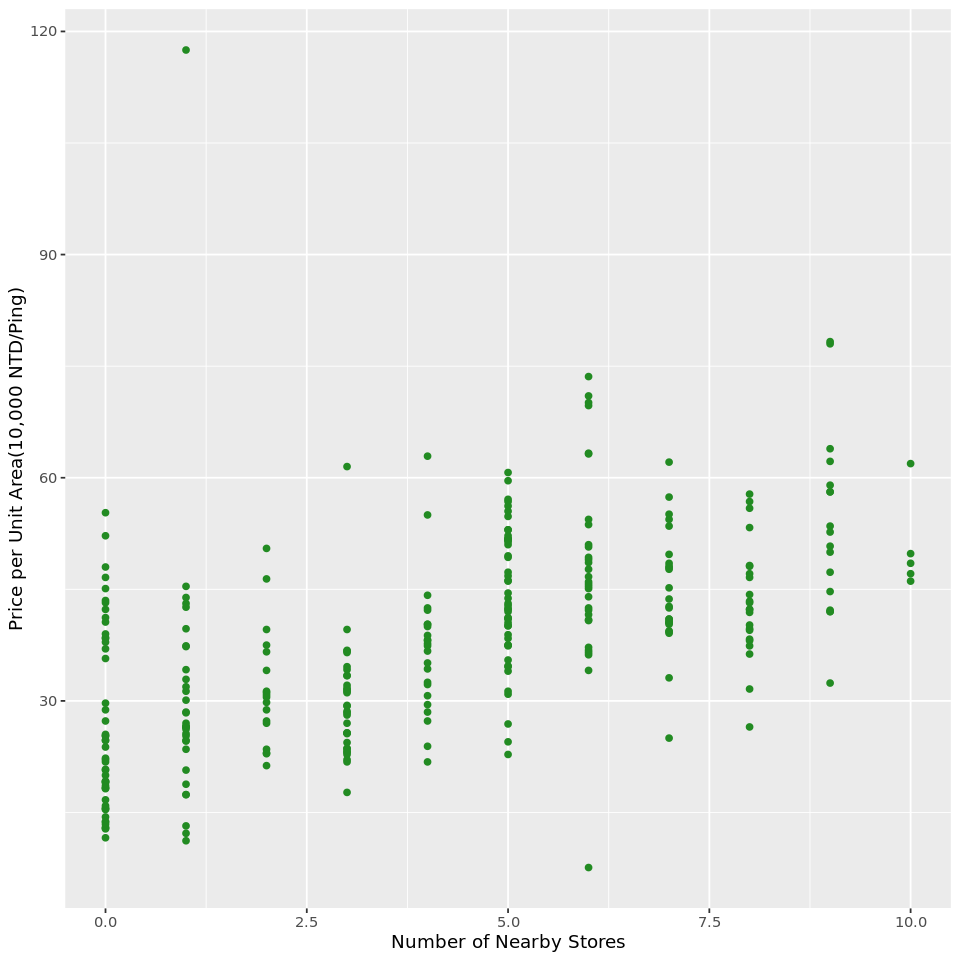

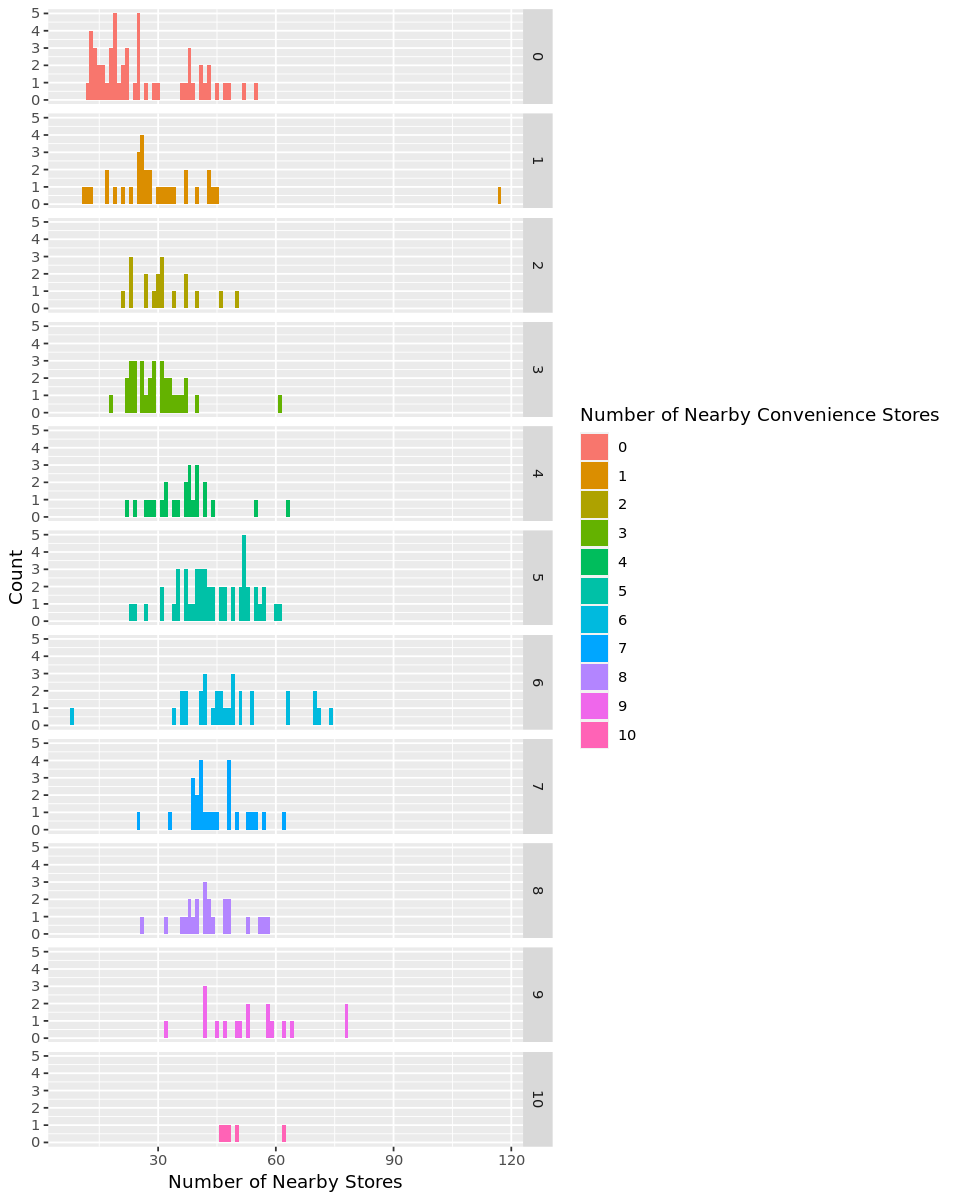

In [6]:
options(repr.plot.width = 8, repr.plot.height = 8)

# age vs price scatterplot
age_price_plot <- house_train |> 
    ggplot(aes(x = age, y = price_per_unit)) +
    geom_point(col = "forestgreen") +
    labs(x = "Age of House (years)", y = "Price per Unit Area(10,000 NTD/Ping)") +
    theme(text = element_text(12))
age_price_plot

# distance to station vs price scatterplot
station_price_plot <- house_train |> 
    ggplot(aes(x = station_distance, y = price_per_unit)) +
    geom_point(col = "forestgreen") +
    labs(x = "Distance to Closest MRT Station (m)", y = "Price per Unit Area(10,000 NTD/Ping)") +
    theme(text = element_text(12))
station_price_plot

# num of nearby stores vs price scatterplot
store_price_plot <- house_train |> 
    ggplot(aes(x = store_count, y = price_per_unit)) +
    geom_point(col = "forestgreen") +
    labs(x = "Number of Nearby Stores", y = "Price per Unit Area(10,000 NTD/Ping)") +
    theme(text = element_text(12))
store_price_plot

options(repr.plot.width = 8, repr.plot.height = 10)

# price distribution of houses, separate by num of nearby stores histogram
store_price_histogram <- house_train |> 
    ggplot(aes(price_per_unit, fill = as_factor(store_count))) +
    geom_histogram(binwidth = 1) +
    facet_grid(rows = vars(store_count)) +
    labs(x = "Number of Nearby Stores", y = "Count", fill = "Number of Nearby Convenience Stores") +
    theme(text = element_text(12))
store_price_histogram

### Methods

**Explain how you will conduct either your data analysis and which variables/columns you will use**

To conduct our data analysis, we will use house age, the distance to the nearest MRT station, and the number of convenience stores within a walkable distance to conduct a K-Nearest-Neighbours regression analysis. This analysis will be used to predict house prices based on the three variables we chose.

**Describe at least one way that you will visualize the results**

One way we will visualize our results is scatterplots of house price vs. our variables with the KNN regression model prediction line shown on the graph. The various variables (house age, distance to nearest MRT station, number of convenience stores within walkable distance) will be shown on the x-axis, and the house price on the y-axis.

### Expected Outcomes

**What do you expect to find?**

We expect to find relationships between both house age and house price, and distance to the nearest MRT station and house price. We would expect there to be a negative relationship between house price and age, as houses lose value the older they get. We would also expect there to be a negative relationship between distance to MRT station and house price, as houses are typically of higher value closer to transit stations.  

**What impact could such findings have?**

These findings could help people determine expected prices when selling or buying properties in New Taipei City. It may also be useful to spot irregular prices, indicating houses that are evaluated much higher or much lower than other comparable homes. 

**What future questions could this lead to?**

Future questions could relate to the possible relationship between house price and other factors such as distance to grocery stores or schools, the average age of residents in the neighbourhood, or the rates of crime in the area. Similar regression analyses could also be conducted with data from other cities around the world, to see if there are regional differences in the relationships between these factors. Furthermore, research could be conducted to determine why these factors influence the price of homes. 